In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

import statsmodels.api as sm

plt.style.use("bmh")

### Simple AR model test

In [2]:
arparams = np.array([.75, -.25])
ar = np.r_[1, -arparams]
maparams = np.array([0, 0])
ma = np.r_[1, maparams] # add zero-lag
y = sm.tsa.arma_generate_sample(ar, ma, 250)

sm.tsa.ARIMA(endog=y, order=(2, 0, 0), trend="n").fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -334.310
Date:                Mon, 16 Jan 2023   AIC                            674.621
Time:                        07:12:29   BIC                            685.185
Sample:                             0   HQIC                           678.873
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6280      0.064      9.836      0.000       0.503       0.753
ar.L2         -0.1462      0.066     -2.223      0.026      -0.275      -0.017
sigma2         0.8479      0.082     10.369      0.000       0.688       1.008
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.98   Prob(JB):                         0.77
Heteroskedasticity (H):               0.98   Skew:                             0.05
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Simulate from multiple stationary AR models

In [3]:
alpha = 0.05
i = 0
summary = {}
while i < 10000:

    arparams = np.array([np.random.uniform(low=-1, high=1, size=1)[0], np.random.uniform(low=-1, high=1, size=1)[0]])
    ar = np.r_[1, -arparams]
    maparams = np.array([0, 0])
    ma = np.r_[1, maparams]
    y = sm.tsa.arma_generate_sample(ar, ma, 100)

    if sm.tsa.stattools.adfuller(y)[1] <= alpha:
        summary[i] = {"y": y, "coefs": arparams}
        i += 1

### Compute statistics from simulated data to be used on the prediction taks

In [9]:
j = 0
k = 0
m = 0

betadgp_beta2x2 = []
cov2x2 = []
corr2x2 = []
for i in range(len(summary.keys())):
    data = pd.DataFrame(summary[i]["y"], columns=["y"])

    for l in range(1, len(summary[i]["coefs"]) + 1):
        data.loc[:, "y_lag{}".format(str(l))] = data["y"].shift(l) 

    data = data.dropna()

    # beta 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        ols_fit = sm.OLS(endog=data["y"], exog=data["y_lag{}".format(str(l))]).fit()
        betadgp_beta2x2.append(pd.DataFrame({j: {"betas_dgp": summary[i]["coefs"][l-1], "beta_2x2": ols_fit.params[0]}}).T)
        j += 1

    # covariance 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        cov2x2.append(pd.DataFrame({k: {"betas_dgp": summary[i]["coefs"][l-1], "cov_dgp": data.cov().iloc[0][l]}}).T)
        k += 1

    # correlation 2x2
    for l in range(1, len(summary[i]["coefs"]) + 1):
        corr2x2.append(pd.DataFrame({k: {"betas_dgp": summary[i]["coefs"][l-1], "corr_dgp": data.corr().iloc[0][l]}}).T)
        m += 1

betadgp_beta2x2_df = pd.concat(betadgp_beta2x2, axis=0)
cov2x2_df = pd.concat(cov2x2, axis=0)
corr2x2_df = pd.concat(corr2x2, axis=0)

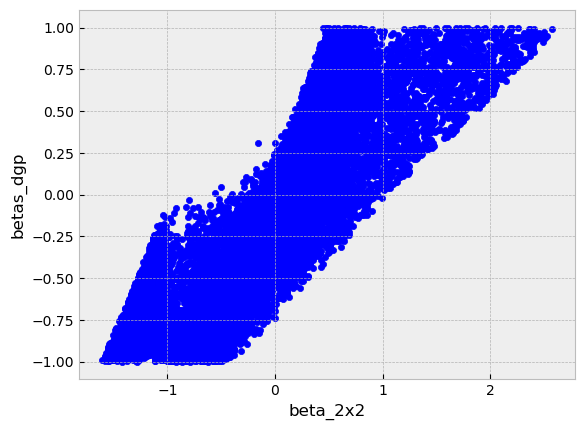

In [10]:
betadgp_beta2x2_df.reset_index(drop=True).plot.scatter(y="betas_dgp", x="beta_2x2")

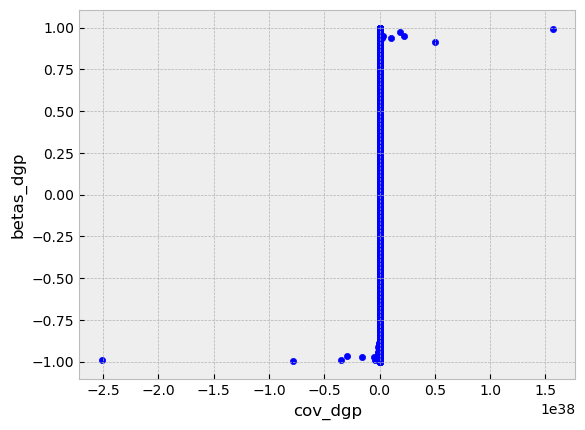

In [11]:
cov2x2_df.reset_index(drop=True).plot.scatter(y="betas_dgp", x="cov_dgp")

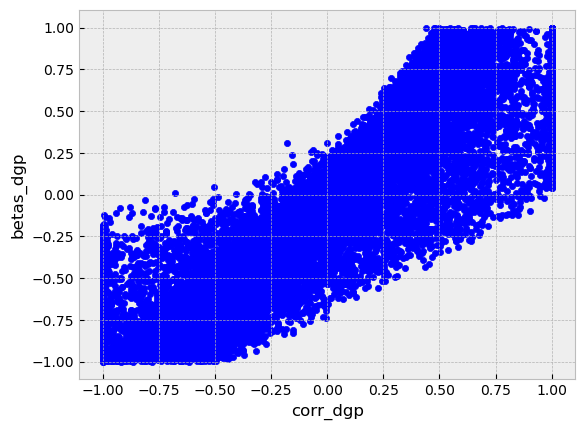

In [12]:
corr2x2_df.reset_index(drop=True).plot.scatter(y="betas_dgp", x="corr_dgp")

In [19]:
target_path = os.path.join(os.getcwd(), "data", "inputs", "simple_ar")

In [21]:
corr2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_corrdgp_data.csv"), index=False)
cov2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_covdgp_data.csv"), index=False)
betadgp_beta2x2_df.reset_index().reset_index().rename(columns={"level_0": "Var1", "level_1": "Var2"}).to_csv(os.path.join(target_path, "betadgp_beta2x2_data.csv"), index=False)

'/Users/danieloliveira/Documents/Daniel/codes/nn-var-cov-pred/src'